In [1]:
'''
SCC5830 - Image Processing
Final Project
2019 - 1st semester

Image restoration: Sinusoidal noise removal
 
'''


'\nSCC5830 - Image Processing\nFinal Project\n2019 - 1st semester\n\nImage restoration: Sinusoidal noise removal\n \n'

In [25]:
import numpy as np
from scipy.fftpack import fftn, ifftn, fftshift, ifft2
import matplotlib.pyplot as plt
import imageio
from PIL import Image

In [135]:
def get_img():
    filename = str(input()).rstrip()
    img = imageio.imread(filename)
    return img

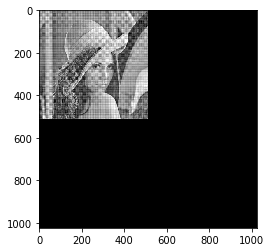

In [17]:
#m, n = img.shape
#nimg = np.zeros((m*2,n*2))
#nimg[:m,:n] = img
#plt.figure()
#plt.imshow(nimg, cmap = "gray")

In [89]:
def spatialtofreq(img):
    m, n = img.shape
    nimg = np.zeros((m*2,n*2))
    nimg[:m,:n] = img
    ftimg = fftn(nimg) 
    ftimg = fftshift(ftimg)
    return ftimg

In [99]:
def freqtospatial(fimg, img):
    m, n = img.shape
    image = np.abs(ifft2(fimg))
    image = image.astype(np.uint8)
    crop_img = image[0:m, 0:n]
    return(crop_img)

In [19]:
#ftimg = fftn(nimg)
#m, n = ftimg.shape
#ftimg = (np.log(1+np.abs(fftshift(ftimg))))
#plt.imshow(np.real(ftimg), cmap = "gray")


NameError: name 'nimg' is not defined

In [91]:
def butterWorthFilter(euclideand, cutofffrequency, bandwidth, order):
            result = 1/(1+((euclideand*bandwidth)/((euclideand**2)-(cutofffrequency**2)))**(2.*order))
            return result

In [92]:
def gaussianFilter(euclideand, cutofffrequency, bandwidth):
            result = 1-np.exp(-((euclideand**2-cutofffrequency**2)/(euclideand*bandwidth))**2)
            return result

In [7]:
def idealFilter(x, y, m, n, r, region):
    dim = size(region)
    for l in range(dim):
        


IndentationError: expected an indented block (<ipython-input-7-589f021f4969>, line 6)

In [93]:
def createBandFilter(m, n, type, cutofffrequency, bandwidth, order):
    img = np.zeros((m,n))
    cx = np.floor(m/2)+1
    cy = np.floor(n/2)+1
    for x in range(m):
        for y in range(n):
            euclideand = np.sqrt((x-cx)**2+(y-cy)**2)
            if(type == "ideal"):
                img[x,y] = idealFilter(euclideand, cutofffrequency, bandwidth)
            elif(type == "butterworth"):
                img[x,y] = butterWorthFilter(euclideand, cutofffrequency, bandwidth, order)
            elif(type == "gaussian"):
                img[x,y] = gaussianFilter(euclideand, cutofffrequency, bandwidth)
    return img

lena_corrupted.png


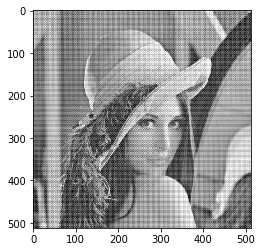

In [141]:
#get image
img = get_img()
plt.imshow(img, cmap = "gray")

In [ ]:
#fimg = fftn(img)
#fimg = (np.log(1+np.abs(fftshift(fimg))))
#plt.figure()
#plt.imshow(fimg, cmap = "gray")

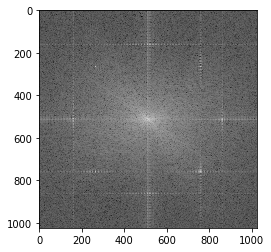

In [142]:
ftimg = spatialtofreq(img)
plt.imshow(np.log(1+np.abs(ftimg)), cmap = "gray")

In [143]:
m,n = fimg.shape
bandwidth = 90
cutofffrequency = 350

/home/gabriel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


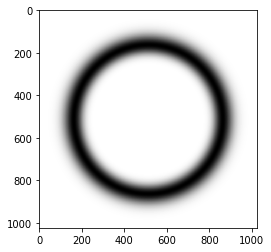

In [144]:
rejectBandFilter = createBandFilter(m, n, "gaussian", cutofffrequency, bandwidth, 2)
plt.imshow(rejectBandFilter, cmap = "gray")

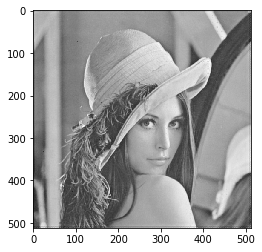

In [145]:
filteredImageRejectBandIdeal =freqtospatial(np.multiply(ftimg,rejectBandFilter),img)
plt.imshow(filteredImageRejectBandIdeal, cmap = "gray")